In [1]:
import sys
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos
from torch.utils.data import DataLoader
from func import OR,heatplot,misorientation,classplot,ipfplot,ipfread,negsample,find_neigh,quaternion
from func2 import create_dataset
from Class import Data,Cluster,Dataset,CNN49ag,CNN49bg
import torch.nn.functional as F
import matplotlib.patches as patches
def parse(subject,src):
    output=dict()
    for i in range(len(src)):
        steel=src[i].split("/")[1]
        if steel not in output:
            output[steel]=subject[i]
        else:
            output[steel]+=subject[i]
    return output
def plotphase(pred,output,w_path):#output: 1->ferrite, 0->martensite
    bgrmap=np.zeros([h-ks+1,w-ks+1,3])
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            if output[i+pad,j+pad]: #ferrite
                bgrmap[i,j]=np.array([1,0,0])
            else:
                bgrmap[i,j]=np.array([0,1,0])
            if pred[i,j]:
                bgrmap[i,j,2]+=1
    cv2.imwrite(w_path,bgrmap*255) 



def survey(results, category_names,text=1):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))
#     category_colors=[(0,0,1,1),(0,1,0,1)]

    fig, ax = plt.subplots(figsize=(9.2, 5))
    plt.xlabel("Content",fontsize=16)
#     plt.xticks.set_visible(False)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    plt.yticks(fontsize=14)
    ax.invert_yaxis()
#     ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        print(color)
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        if text:
            for y, (x, c) in enumerate(zip(xcenters, widths)):
                ax.text(x, y, "%.2f"%(c), ha='center', va='center',
                        color=text_color,fontsize=16)
    ax.legend(ncol=2, bbox_to_anchor=(0, 1),
              loc='lower left',fontsize=16)
#     len(category_names)

    return fig, ax


## Load Data

In [2]:
model_path = "model/CNN_thesis2/0.736_CNN49ag_BS_Quaternion.pkl"
model_name=model_path.split("/")[-1].replace(".pkl","")
feature=model_path.replace(".pkl","").split("/")[-1].split("_")[2:]
header=['ND面硬度(Hv)', 'TD面硬度(Hv)', 'UTS strain(%)', 'UTS stress(MPa)','Total Elongation(%)', 'E(GPa)', 'Ys(Mpa)']
prop_dic=torch.load("data/properties.pkl")
h=w=499
ks=49
pad=24
m1 = torch.load(model_path)
m1.eval()

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'Class.CNN49ag' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `t

CNN49ag(
  (batchnorm): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn1): Conv2d(5, 12, kernel_size=(2, 2), stride=(1, 1))
  (cnn2): Conv2d(12, 18, kernel_size=(3, 3), stride=(1, 1))
  (cnn3): Conv2d(18, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1958, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [3]:
try:
    data,props,src=torch.load("data/"+model_name+"/data.pkl")
except:
    train=create_dataset("train",steels=["590","780","980","1180"],feature=feature,prop_dic=prop_dic,pic_size=h,
                     sam_size=ks,prediction=1)
    val=create_dataset("val",steels=["590","780","980","1180"],feature=feature,prop_dic=prop_dic,pic_size=h,
                         sam_size=ks,prediction=1)
    test=create_dataset("test",steels=["590","780","980","1180"],feature=feature,prop_dic=prop_dic,pic_size=h,
                         sam_size=ks,prediction=1)
    data=torch.cat([train[0],val[0],test[0]])
    props=torch.cat([train[1],val[1],test[1]])
    src=train[2]+val[2]+test[2]
    os.mkdir("data/"+model_name)
    torch.save([data,props,src],"data/"+model_name+"/data.pkl")
num=data.shape[0]
try:
    pred=torch.load("data/"+model_name+"/pred.pkl")
except:
    data=data.cuda()
    props=props.cuda()
    pred=np.zeros([data.shape[0],h-ks+1,w-ks+1])
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            output=m1(data[:,:,i:i+ks,j:j+ks],props)
            for k in range(num):
                pred[k,i,j]+=output[k,0].detach().item()
            del output
    torch.save(pred,"data/"+model_name+"/pred.pkl")


## MF

In [ ]:
#ferrite,martensite
prob=np.zeros([num,2]) 
pixels=np.zeros([num,2])        
for ite,path in enumerate(src):
    class_map,id2clus,ma_id=torch.load(path+"cluster.pkl")
    pad=24
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            if class_map[pad+i,pad+j] in ma_id:
                prob[ite,1]+=pred[ite,i,j]
                pixels[ite,1]+=1
            else:
                prob[ite,0]+=pred[ite,i,j]
                pixels[ite,0]+=1
prob=parse(prob,src)
pixels=parse(pixels,src)
length=dict()
result=dict()
for key in list(prob.keys()):
    length[key]=pixels[key]*0.1
    result[key]=prob[key]/pixels[key]
# with pd.ExcelWriter('output/MF.xlsx') as writer: 
#     pd.DataFrame(prob).to_excel(writer,sheet_name='prob', index=False, header=True,float_format='%d')
#     pd.DataFrame(pixels).to_excel(writer,sheet_name='pixels', index=False, header=True,float_format='%d')
#     pd.DataFrame(result).to_excel(writer,sheet_name='result', index=False, header=True,float_format='%.3f')
file = open("output/MF.csv","w")
headers=["prob","pixels","length","result"]
for key in list(prob.keys()):
    for i,attr in enumerate([prob,pixels,length,result]):
        for ele in attr[key]:
            file.write("%.3f,"%(ele))
        file.write("\n")
file.close()

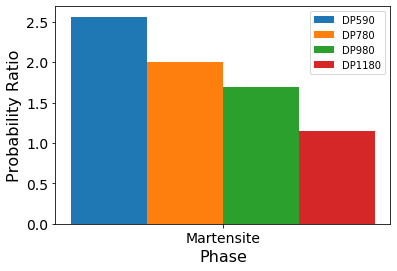

In [4]:

df=pd.read_excel("output/MF.xlsx",sheet_name="result")
category_names = ["Martensite"]
x = np.arange(len(category_names)).astype("float")
width = 0.2
plot=[]
for name in df.columns:
    plt.bar(x - 3*width/2,df[name][1:]/df[name][0],width,label="DP"+name)
    x+=width
plt.xticks(np.arange(len(df[name][1:])), category_names,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Phase",fontsize=16)
plt.ylabel('Probability Ratio',fontsize=16)
plt.legend(fontsize=10)
plt.savefig("output/MF_prob_bar_rate.png",dpi=600,bbox_inches='tight', pad_inches=0.2)
plt.show()

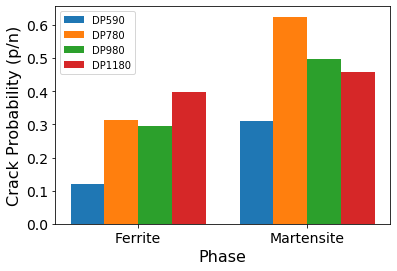

In [5]:

df=pd.read_excel("output/MF.xlsx",sheet_name="result")
category_names = ["Ferrite","Martensite"]
x = np.arange(len(category_names)).astype("float")
width = 0.20 
plot=[]
for name in df.columns:
    plt.bar(x - 3*width/2,df[name],width,label="DP"+name)
    x+=width
plt.xticks(np.arange(len(df[name])), category_names,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Phase",fontsize=16)
plt.ylabel('Crack Probability (p/n)',fontsize=16)
# plt.legend(fontsize=10,ncol=4, bbox_to_anchor=(0, 1),loc='lower left')
plt.legend(fontsize=10)
plt.savefig("output/MF_prob_bar.png",dpi=600,bbox_inches='tight', pad_inches=0.2)
plt.show()

[0.89888504 0.30549789 0.20676663 1.        ]
[0.24805844 0.66720492 0.3502499  1.        ]


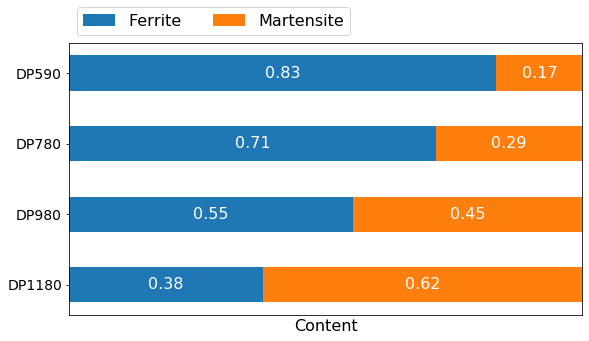

In [6]:
df=pd.read_excel("output/MF.xlsx",sheet_name="pixels")
dic=dict()
for name in df.columns:
    dic["DP"+name]=df[name]/np.sum(df[name])
category_names = ["Ferrite","Martensite"]
results = dic
survey(results, category_names)
plt.savefig("output/MF.png",dpi=600)
plt.show()

## MFedge

In [ ]:
#0 ferrite in ferrite
#1 martensite in martensite
#2 ferrite in ferrite bd
#3 ferrite in martensite bd/martensite in ferrite bd

prob=np.zeros([num,4]) #ferrite,martensite
pixels=np.zeros([num,4])        
pad=24
neigh=np.array([[1,0],[-1,0],[0,1],[0,-1]])
for ind,path in enumerate(src):
    class_map,id2clus,ma_id=torch.load(path+"cluster.pkl")
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            types=[]
            if class_map[pad+i,pad+j] in ma_id:
                for (n0,n1) in neigh:
                    if class_map[pad+i+n0,pad+j+n1] in ma_id:
                        types.append(1) #martensite
                    else:
                        types.append(3)
            else:
                for (n0,n1) in neigh:
                    if class_map[pad+i+n0,pad+j+n1] in ma_id:
                        types.append(3)
                    else:
                        if class_map[pad+i+n0,pad+j+n1]==class_map[pad+i,pad+j]:
                            types.append(0)
                        else:
                            types.append(2)
            for ele in types:
                prob[ind,ele]+=pred[ind,i,j]
                pixels[ind,ele]+=1
prob=parse(prob,src)
pixels=parse(pixels,src)
length=dict()
result=dict()
for key in list(prob.keys()):
    length[key]=pixels[key]*0.1
    result[key]=prob[key]/pixels[key]
with pd.ExcelWriter('output/MFedge.xlsx') as writer: 
    pd.DataFrame(prob).to_excel(writer,sheet_name='prob', index=False, header=True,float_format='%d')
    pd.DataFrame(pixels).to_excel(writer,sheet_name='pixels', index=False, header=True,float_format='%d')
    pd.DataFrame(result).to_excel(writer,sheet_name='result', index=False, header=True,float_format='%.3f')
file = open("output/MFedge.csv","w")
headers=["prob","pixels","length","result"]
for key in list(prob.keys()):
    for i,attr in enumerate([prob,pixels,length,result]):
        for ele in attr[key]:
            file.write("%.3f,"%(ele))
        file.write("\n")
file.close()

[0.89888504 0.30549789 0.20676663 1.        ]
[0.99546328 0.84767397 0.51926182 1.        ]
[0.81960784 0.92372165 0.52479815 1.        ]
[0.24805844 0.66720492 0.3502499  1.        ]


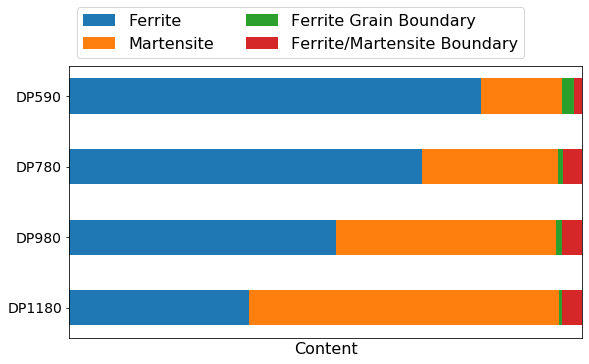

In [16]:
df=pd.read_excel("output/MFedge.xlsx",sheet_name="pixels")
dic=dict()
for name in df.columns:
    dic["DP"+name]=df[name]/np.sum(df[name])

category_names = ["Ferrite","Martensite","Ferrite Grain Boundary","Ferrite/Martensite Boundary"]
results = dic

survey(results, category_names,0)
plt.savefig("output/MFedge.png",dpi=600,bbox_inches='tight', pad_inches=0.2)
plt.show()

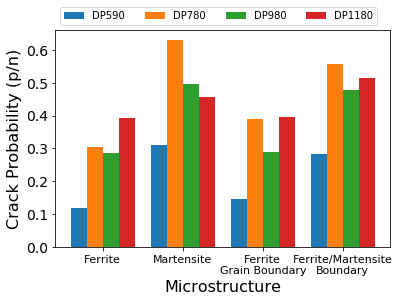

In [7]:
df=pd.read_excel("output/MFedge.xlsx",sheet_name="result")
category_names = ["Ferrite","Martensite","Ferrite\nGrain Boundary","Ferrite/Martensite\nBoundary"]
x = np.arange(len(category_names)).astype("float")
width = 0.20 
plot=[]
for name in df.columns:
    plt.bar(x - 3*width/2,df[name],width,label="DP"+name)
    x+=width
plt.xticks(np.arange(len(df[name])), category_names,fontsize=11)
plt.yticks(fontsize=14)
plt.xlabel("Microstructure",fontsize=16)
plt.ylabel('Crack Probability (p/n)',fontsize=16)
# plt.legend(fontsize=10)
plt.legend(fontsize=10,ncol=4, bbox_to_anchor=(0, 1),loc='lower left')
plt.savefig("output/MF_edge_bar.png",dpi=600,bbox_inches='tight', pad_inches=0.2)
plt.show()

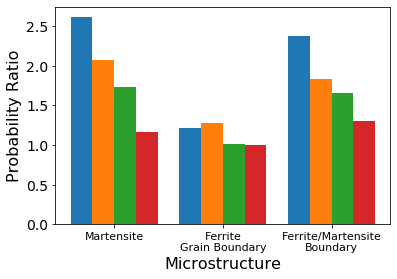

In [5]:
df=pd.read_excel("output/MFedge.xlsx",sheet_name="result")
category_names = ["Martensite","Ferrite\nGrain Boundary","Ferrite/Martensite\nBoundary"]
x = np.arange(len(category_names)).astype("float")
width = 0.20 
plot=[]
for name in df.columns:
    plt.bar(x - 3*width/2,df[name][1:]/df[name][0],width,label="DP"+name)
    x+=width
plt.xticks(np.arange(len(df[name][1:])), category_names,fontsize=11)
plt.yticks(fontsize=14)
plt.xlabel("Microstructure",fontsize=16)
plt.ylabel('Probability Ratio',fontsize=16)
plt.savefig("output/MF_edge_bar_ratio.png",dpi=600,bbox_inches='tight', pad_inches=0.2)
plt.show()

## MFcenterpixel

In [ ]:
#0 ferrite in ferrite
#1 martensite in martensite
#2 ferrite in ferrite bd
#3 ferrite in martensite bd and martensite in ferrite bd
#4 ferrite in martensite bd and ferrite bd
prob=np.zeros([num,5]) #ferrite,martensite
pixels=np.zeros([num,5])        
neigh=np.array([[1,0],[-1,0],[0,1],[0,-1]])
for ind,path in enumerate(src):
    class_map,id2clus,ma_id=torch.load(path+"cluster.pkl")
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            types=[]
            if class_map[pad+i,pad+j] in ma_id:
                for (n0,n1) in neigh:
                    if class_map[pad+i+n0,pad+j+n1] in ma_id:
                        types.append(1) 
                    else:
                        types.append(3)
                if 3 in types:
                    prob[ind,3]+=pred[ind,i,j]
                    pixels[ind,3]+=1
                else:
                    prob[ind,1]+=pred[ind,i,j]
                    pixels[ind,1]+=1
            else:
                for (n0,n1) in neigh:
                    if class_map[pad+i+n0,pad+j+n1] in ma_id:
                        types.append(3)
                    else:
                        if class_map[pad+i+n0,pad+j+n1]==class_map[pad+i,pad+j]:
                            types.append(0)
                        else:
                            types.append(2)
                if 2 in types and 3 in types:
                    prob[ind,4]+=pred[ind,i,j]
                    pixels[ind,4]+=1
                elif 2 in types:
                    prob[ind,2]+=pred[ind,i,j]
                    pixels[ind,2]+=1
                elif 3 in types:
                    prob[ind,3]+=pred[ind,i,j]
                    pixels[ind,3]+=1
                else:
                    prob[ind,0]+=pred[ind,i,j]
                    pixels[ind,0]+=1
prob=parse(prob,src)
pixels=parse(pixels,src)
length=dict()
result=dict()
for key in list(prob.keys()):
    length[key]=pixels[key]*0.1
    result[key]=prob[key]/pixels[key]
with pd.ExcelWriter('output/MFcenterpixel.xlsx') as writer: 
    pd.DataFrame(prob).to_excel(writer,sheet_name='prob', index=False, header=True,float_format='%d')
    pd.DataFrame(pixels).to_excel(writer,sheet_name='pixels', index=False, header=True,float_format='%d')
    pd.DataFrame(result).to_excel(writer,sheet_name='result', index=False, header=True,float_format='%.3f')
file = open("output/MFcenterpixel.csv","w")
headers=["prob","pixels","length","result"]
for key in list(prob.keys()):
    for i,attr in enumerate([prob,pixels,length,result]):
        for ele in attr[key]:
            file.write("%.3f,"%(ele))
        file.write("\n")
file.close()

[0.89888504 0.30549789 0.20676663 1.        ]
[0.99315648 0.73233372 0.42237601 1.        ]
[0.99707805 0.9987697  0.74502115 1.        ]
[0.70196078 0.87297193 0.44867359 1.        ]
[0.24805844 0.66720492 0.3502499  1.        ]


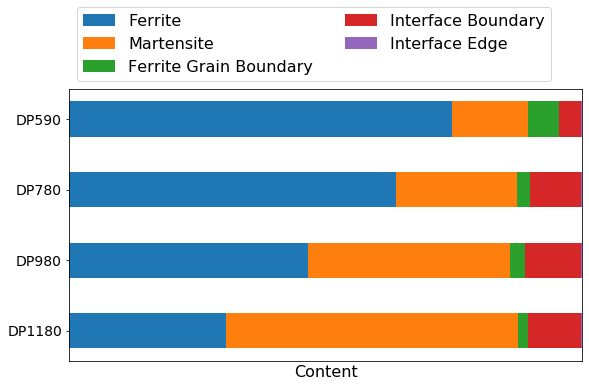

In [14]:
df=pd.read_excel("output/MFcenterpixel.xlsx",sheet_name="pixels")
dic=dict()
for name in df.columns:
    dic["DP"+name]=df[name]/np.sum(df[name])
category_names = ["Ferrite","Martensite","Ferrite Grain Boundary","Interface Boundary",
                 "Interface Edge"]
results = dic
survey(results, category_names,0)
plt.savefig("output/MFcenterpixel.png",dpi=600,bbox_inches='tight', pad_inches=0.2)
plt.show()

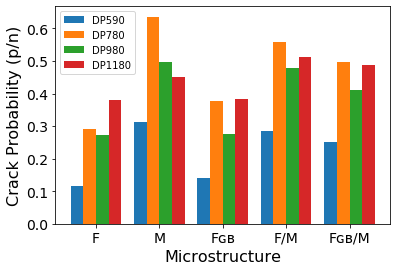

In [16]:
df=pd.read_excel("output/MFcenterpixel.xlsx",sheet_name="result")
category_names = ["F","M","Fɢʙ","F/M","Fɢʙ/M"]
x = np.arange(len(category_names)).astype("float")
width = 0.20 
plot=[]
for name in df.columns:
    plt.bar(x-3*width/2,df[name],width,label="DP"+name)
    x+=width
plt.xticks(np.arange(len(df[name])), category_names,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Microstructure",fontsize=16)
plt.ylabel('Crack Probability (p/n)',fontsize=16)
# plt.legend(fontsize=10,ncol=4, bbox_to_anchor=(0, 1),loc='lower left')
plt.legend(fontsize=10)
plt.savefig("output/MFcenterpixel_prob_bar.png",dpi=600,bbox_inches='tight', pad_inches=0.2)
plt.show()

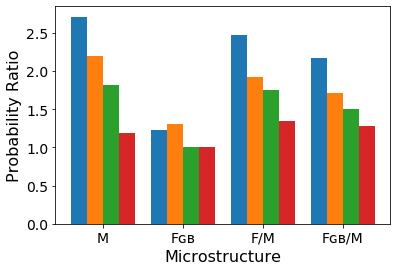

In [15]:
df=pd.read_excel("output/MFcenterpixel.xlsx",sheet_name="result")
category_names = ["M","Fɢʙ","F/M","Fɢʙ/M"]
x = np.arange(len(category_names)).astype("float")
width = 0.20 
plot=[]
for name in df.columns:
    plt.bar(x-3*width/2,df[name][1:]/df[name][0],width,label="DP"+name)
    x+=width
plt.xticks(np.arange(len(df[name][1:])), category_names,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Microstructure",fontsize=16)
plt.ylabel('Probability Ratio',fontsize=16)
plt.savefig("output/MFcenterpixel_prob_bar_ratio.png",dpi=600,bbox_inches='tight', pad_inches=0.2)
plt.show()

## Phase Identification Result

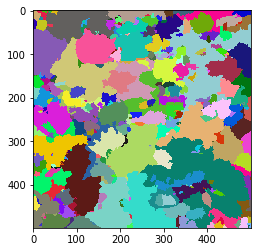

True

In [4]:
index=0
for i in range(len(src)):
    if "20201109" in src[i]:
        index=i
        break
sum_map=pred[index]
cv2.imwrite("output/20201109_451451.png",sum_map*255)
cv2.imwrite("output/20201109_451451_inv.png",(1-sum_map)*255)
class_map,id2clus,ma_id=torch.load(src[index]+"cluster.pkl")
class_img=classplot(class_map)[24:475,24:475,:]
ipf=ipfread(src[index])[24:475,24:475,6:]
cv2.imwrite("output/20201109_class.png",class_img)
cv2.imwrite("output/20201109_ipf_b.png",ipf)
for i in range(3):
    ipf[:,:,i]=np.multiply(1-sum_map,ipf[:,:,i])
    class_img[:,:,i]=np.multiply(1-sum_map,class_img[:,:,i])
cv2.imwrite("output/20201109_ipf_d.png",ipf)
cv2.imwrite("output/20201109_class_d.png",class_img)

## Crack Propagation

In [35]:
#prob vs differnt phase
interval=np.arange(0.9,1.001,0.001)
num_phase=np.zeros([len(src),len(interval),2]) #ferrite,martensite
pixels=np.zeros([len(src),2])
for ind,path in enumerate(src):
    class_map,id2clus,ma_id=torch.load(path+"cluster.pkl")
    cur_map=pred[ind]
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            if class_map[pad+i,pad+j] in ma_id:
                pixels[ind,1]+=1
            else:
                pixels[ind,0]+=1
    for ite,ele in enumerate(interval):
        for i in range(h-ks+1):
            for j in range(w-ks+1):
                if cur_map[i,j]>=ele:
                    if class_map[pad+i,pad+j] in ma_id:
                        num_phase[ind,ite,1]+=1
                    else:
                        num_phase[ind,ite,0]+=1                        
pixels=parse(pixels,src)
num_phase=parse(num_phase,src)
result=dict()
for key in list(pixels.keys()):
    result[key]=num_phase[key]/pixels[key]



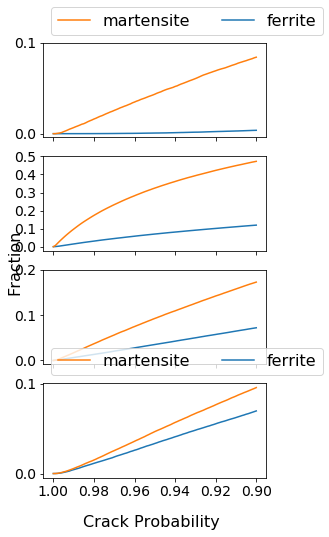

In [44]:
fig = plt.figure(figsize=(4,8))
p_order=411
for steel in ["590","780","980","1180"]:
    if steel=="1180":
        ax1=plt.subplot(p_order)
    else:
        ax1=plt.subplot(p_order)
        plt.setp(ax1.get_xticklabels(), visible=False)
        
    p_order+=1
    p1,=plt.plot(interval,result[steel][:,0])
    p2,=plt.plot(interval,result[steel][:,1])
    ax = p1.axes
    ax.invert_xaxis()
#     plt.ylabel("DP"+steel,fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(0, np.max(result[steel][:,1])+0.1,step=0.1),fontsize=14)
    if steel=="590":
        plt.legend([p2,p1],["martensite","ferrite"],fontsize=16,ncol=2, bbox_to_anchor=(0, 1),loc='lower left')

    
fig.text(0.5, 0.04, 'Crack Probability', ha='center',fontsize=16)
fig.text(0.0, 0.5, 'Fraction', va='center', rotation='vertical',fontsize=16)
# plt.legend([p2,p1],["martensite","ferrite"],fontsize=16)
plt.legend([p2,p1],["martensite","ferrite"],fontsize=16,ncol=2, bbox_to_anchor=(0, 1),loc='lower left')

plt.savefig("output/921_3.png",dpi=600,bbox_inches='tight', pad_inches=0.2)
plt.show()

In [ ]:
#prob vs differnt phase
interval=np.arange(0.5,1.001,0.001)
num_phase=np.zeros([len(src),len(interval),2]) #ferrite,martensite
pixels=np.zeros([len(src),2])
for ind,path in enumerate(src):
    class_map,id2clus,ma_id=torch.load(path+"cluster.pkl")
    cur_map=pred[ind]
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            if class_map[pad+i,pad+j] in ma_id:
                pixels[ind,1]+=1
            else:
                pixels[ind,0]+=1
    for ite,ele in enumerate(interval):
        for i in range(h-ks+1):
            for j in range(w-ks+1):
                if cur_map[i,j]>=ele:
                    if class_map[pad+i,pad+j] in ma_id:
                        num_phase[ind,ite,1]+=1
                    else:
                        num_phase[ind,ite,0]+=1                        
pixels=parse(pixels,src)
num_phase=parse(num_phase,src)
result=dict()
for key in list(pixels.keys()):
    result[key]=num_phase[key]/pixels[key]
for steel in ["590","780","980","1180"]:
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Probability",fontsize=16)
    plt.ylabel('Fraction',fontsize=16)
    plt.title("DP"+steel,fontsize=16)
    p1,=plt.plot(interval,result[steel][:,0])
    p2,=plt.plot(interval,result[steel][:,1])
    ax = p1.axes
    ax.invert_xaxis()
    plt.legend([p2,p1],["martensite","ferrite"],fontsize=16)
    plt.savefig("output/fraction/%s_0.5_1.png"%(steel),dpi=600,bbox_inches='tight', pad_inches=0.2)
    plt.show()


In [7]:
path=src[index]
class_map,id2clus,ma_id=torch.load(path+"cluster.pkl")
output=np.ones([h,w])
pred=torch.load("data/"+model_name+"/pred.pkl")
for i in range(h):
    for j in range(w):
        if class_map[i,j] in ma_id:
            output[i,j]=0  


In [10]:
ipf=ipfread(src[index])[24:475,24:475,6:]
pred=torch.load("data/"+model_name+"/pred.pkl")    
class_map,id2clus,ma_id=torch.load(path+"cluster.pkl")
interval=np.arange(0.4,1.01,0.1)
for ite,ele in enumerate(interval[::-1]):
    ipf_cur=ipf.copy()
    for i in range(3):
        ipf_cur[:,:,i]=np.multiply(1-(pred[index]>=ele),ipf[:,:,i])
    cv2.imwrite("output/20201109_prob/IPFZ/%.2f.png"%(ele),ipf_cur)
    cv2.imwrite("output/20201109_prob/binary/%.2f.png"%(ele),(1-(pred[index]>ele))*255)

In [11]:
for prob in [1,0.9,0.8,0.7,0.6,0.5]:
    plotphase(pred[index]>=prob,output,"output/20201109_prob/phase/%.2f.png"%(prob))

In [14]:
#prob+bfs
crack_prop=[]
ipf=ipfread(src[index])[24:475,24:475,6:]
cracks=dict()
outmap=np.zeros([h-ks+1,w-ks+1])
ite=1
for i in range(h-ks+1):
    for j in range(w-ks+1):
        if pred[index,i,j]>0.95:
            cracks[ite]=Cluster(ite,i,j)
            outmap[i,j]=1
            ite+=1
crack_prop.append(outmap)
cv2.imwrite("output/20201109_crack_prop/binary/%.2f.png"%(0),(1-outmap)*255)
ipf_cur=ipf.copy()
for i in range(3):
    ipf_cur[:,:,i]=np.multiply(1-outmap,ipf[:,:,i])
cv2.imwrite("output/20201109_crack_prop/IPFZ/%.2f.png"%(0),ipf_cur)
plotphase(outmap,output,"output/20201109_crack_prop/Phase/%d.png"%(0))

for thres in np.arange(0.01,0.06,0.01):
    for key in list(cracks.keys()):
        to_travel=cracks[key].pixels.copy()
        while len(to_travel)>0:
            i,j=to_travel.pop()
            cracks[key].add(i,j)
            for m,n in find_neigh((i,j),h-ks+1,w-ks+1):
                if pred[index,m,n]>pred[index,i,j]-thres:
                    if (m,n) not in cracks[key].pixels:
                        to_travel.add((m,n))
    outmap=np.zeros([h-ks+1,w-ks+1])
    for key in list(cracks.keys()):
        to_travel=cracks[key].pixels.copy()
        while len(to_travel)>0:
            i,j=to_travel.pop()
            outmap[i,j]=1
    crack_prop.append(outmap)
    cv2.imwrite("output/20201109_crack_prop/binary/%.2f.png"%(thres),(1-outmap)*255)
    plotphase(outmap,output,"output/20201109_crack_prop/Phase/%.2f.png"%(thres))
    ipf_cur=ipf.copy()
    for i in range(3):
        ipf_cur[:,:,i]=np.multiply(1-outmap,ipf[:,:,i])
    cv2.imwrite("output/20201109_crack_prop/IPFZ/%.2f.png"%(thres),ipf_cur)

    

In [7]:
#iterative changing the data and output the probabilities
#Phase_BC_Bands_Error_Quaternion
change=[]
min_set={"Phase","BC","Bands","MAD","BS"}
max_set={"Error"}
for i,ele in enumerate(feature):
    if ele in min_set:
        change.append(torch.min(data[:,i]))
    elif ele in max_set:
        change.append(torch.max(data[:,i]))
    elif ele=="Quaternion":
        change=change+[1,0,0,0]
    else:
        change.append(torch.max(data[:,i]))
change=torch.tensor(change)

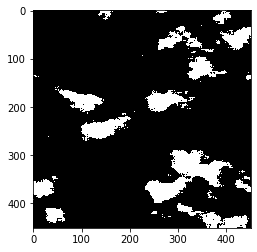

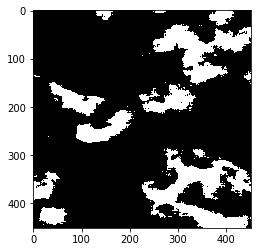

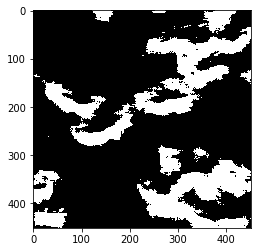

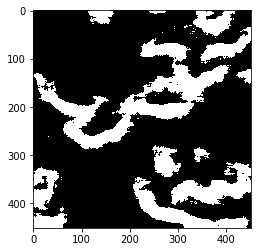

KeyboardInterrupt: 

In [9]:
m1=m1.cuda()
for ite in range(1,11):
    for n in range(num):
        for i in range(h-ks+1):
            for j in range(w-ks+1):
                if pred[n,i,j]>0.99:
                    data[n,:,i+pad,j+pad]=change
    data=data.cuda()
    props=props.cuda()
    pred=np.zeros([data.shape[0],h-ks+1,w-ks+1])
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            output=m1(data[:,:,i:i+ks,j:j+ks],props)
            for k in range(num):
                pred[k,i,j]+=output[k,0].detach().item()
            del output
    plt.imshow(pred[index]>0.99,cmap="gray")
    plt.show()
    torch.save(pred,"data/"+model_name+"/pred_%d.pkl"%(ite))
    torch.save(data,"data/"+model_name+"/data_%d.pkl"%(ite))



In [13]:
ipf=ipfread(src[index])[24:475,24:475,6:]
for ite in range(0,11):
    ipf_cur=ipf.copy()
    if ite==0:
        pred=torch.load("data/"+model_name+"/pred.pkl")
    else:
        pred=torch.load("data/"+model_name+"/pred_%d.pkl"%(ite))
    for i in range(3):
        ipf_cur[:,:,i]=np.multiply(1-(pred[index]>0.99),ipf[:,:,i])
    cv2.imwrite("output/20201109_iter/IPFZ/%d.png"%(ite),ipf_cur)
    cv2.imwrite("output/20201109_iter/binary/%d.png"%(ite),(1-(pred[index]>0.99))*255)
    plotphase(pred[index]>0.99,output,"output/20201109_iter/phase/%d.png"%(ite))
    

In [31]:
corner=torch.load("data/780_corner.pkl")
pred=np.zeros([500,500])
for i,j in corner["20201109"]:
    pred[i:i+49,j:j+49]=np.ones([49,49])
# plotphase(pred[24:475,24:475],output,"output/20201109_prob/origin.png")


In [34]:
pred=np.zeros([500,500])
bgrmap=np.zeros([h,w,3])
for i in range(h):
    for j in range(w):
        if output[i,j]: #ferrite
            bgrmap[i,j]=np.array([1,0,0])
        else:
            bgrmap[i,j]=np.array([0,1,0])
        if pred[i,j]:
            bgrmap[i,j,2]+=1
cv2.imwrite("output/20201109_prob/background.png",bgrmap*255) 

True